# DSCI 572 Lecture 2

Learning goals:

- why do we need gradient descent? Can't we use the normal equations for everything?
- what is the step size? what role does it play?
- how do I implement gradient descent?
- what's the difference between the data space and the parameter space?


In [2]:
import numpy as np
import numpy.random as npr
import sklearn
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

### Motivation

//anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


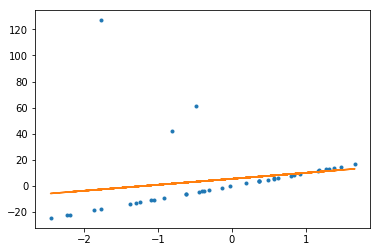

In [3]:
# generate random data
x = np.random.randn(40)
y = 10*x
# add random outliers
Noutliers = 3
y[:Noutliers] = -100*(x[:Noutliers]+np.random.randn(Noutliers))

# plot the points
plt.plot(x,y,'.')

X = x[:,None] # reshape for sklearn

# fit a linear regression model
lr = sklearn.linear_model.LinearRegression()
lr.fit(X,y)
plt.plot(x, lr.predict(X))
plt.show()


## Gradient descent

#### use of the gradient: optimization

The gradient gives us the direction of fastest increase.

The (negative) gradient gives us a direction of travel (fastest decrease), if we want to minimize a function!

If we are trying to minimize $f(\mathbf{w})$, then gradient descent works by starting with some initial guess $\mathbf{w}_0$ and then updating with

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \alpha\, \nabla f(\mathbf{w}_{t})$$

- Note: gradient descent is an algorithm for minimization. The corresponding method for maximization is called gradient ascent.
- (optional note): physicists like me tend to think about _units_. Note that $f$ and $\nabla f$ have different units, which means the learning rate has units. That seems weird, since we'd hope to pick the learning rate irrespective of the scaling of our probelm. If this bothers you, see [this blog post](http://timvieira.github.io/blog/post/2016/05/27/dimensional-analysis-of-gradient-ascent/).


#### magnitude vs. direction

In the above we are making use of the magnitude of the gradient, not just its direction. This actually makes sense. When the magnitude is small, we are in a flatter area and want to take smaller steps. 

However, some methods exist that just use the direction. For example given a direction you can do a [line search](https://en.wikipedia.org/wiki/Line_search).

#### picking the learning rate

In general picking $\alpha$ is a pain. There is theory on this regarding convergence guarantees and convergence rates. The learning rate is sometimes decreased over time. Fancier methods pick the learning rate adaptively.

#### termination conditions

We can stop when $||\nabla f||$ is sufficiently small (because this indicates we're at a local minimum), or when a specified maximum number of iterations are reached (because we want to limit the computational expense).

#### why gradient descent

Question: why do we want to use the gradient? 

- One way to think about it is that you get $d$ times more information than just the function value
- Because it takes $d+1$ evaluations to estimate the gradient (we'll discuss this in lecture 4)

## Least squares via normal equations vs. gradient descent:

- Normal equations cost $\mathcal{O}(nd^2 + d^3)$.
  - forming $X^TX$ costs $\mathcal{O}(nd^2)$ and solving a $d\times d$ linear system costs $\mathcal{O}(d^3)$
- Gradient descent costs $\mathcal{O}(ndt)$ to run for $t$ iterations.
  - computing $\nabla f(\mathbf{w})=X^TXw-X^Ty$ only costs $\mathcal{O}(nd)$ 
- Gradient descent can be faster when $d$ is very large
  - well, this is just big-O, we don't know the coeffcients
  - matrix operations are fast. iteration is slow, especially in Python
  - gradient descent is usually not the way to go with OLS, but we'll see its usefulness below

## Experiments: does it work?

In [4]:
# generate data
d = 10
n = 1000

X = npr.randn(n,d)
y = npr.randn(n)

#### Approach 1: sklearn's `LinearRegression` in Python

In [5]:
# sklearn least squares

lr = sklearn.linear_model.LinearRegression()
lr.fit(X,y)
print("Intercept: %f" % lr.intercept_)
print("Weights: %s" % lr.coef_)

Intercept: 0.062178
Weights: [-0.07213192  0.01987202  0.01459727 -0.01288836 -0.01902805  0.00413323
  0.02713685 -0.01435118 -0.05219488  0.03030086]


**Approach 2: normal equations**

In [6]:
# add a feature of all 1's for intercept 
X = np.append(np.ones(X.shape[0])[:,None], X, axis=1)

In [7]:
weights = np.linalg.solve(X.T@X,X.T@y)

print("Intercept: %f" % weights[0])
print("Weights: %s" % weights[1:])

Intercept: 0.062178
Weights: [-0.07213192  0.01987202  0.01459727 -0.01288836 -0.01902805  0.00413323
  0.02713685 -0.01435118 -0.05219488  0.03030086]


#### Approach 3: gradient descent

In [8]:
XTX = X.T@X
XTy = X.T@y

alpha = 0.00001

grad_f = lambda w: XTX@w - XTy

In [9]:
w = np.zeros(X.shape[1])

while True:
    g = grad_f(w)
    
    if np.linalg.norm(g) < 0.001:
        break
    
    w -= alpha*g

In [10]:
print("Intercept: %f" % w[0])
print("Weights: %s" % w[1:])

Intercept: 0.062178
Weights: [-0.07213137  0.01987176  0.01459749 -0.01288823 -0.01902813  0.00413327
  0.02713649 -0.01435147 -0.05219444  0.03030024]


From the above, you can see that all three methods generate the same weights. This is comforting.

## Why gradient descent?

If we can solve least squares in closed form with linear algebra, why do we want gradient descent?

Answer: the fact that we can write the solution in closed form as a system of linear equations is amazing! (Think about it.) This is a very special case. For almost any other loss function, we can't do this.

For example with gradient descent we can minimize the absolute value objective

$$ f(\mathbf{w}) = \sum_{n=1}^N\left|\mathbf{w}^\top\mathbf{x_n}-y_n\right| $$

with gradient descent. This is the sum of absolute values instead of the sum of squares. This will hopefully give us robust regression because big distances aren't amplified in the objective (let's dwell on this reasoning for a bit).

**Note:** You might point out that this function is non-differentiable. See the bonus material at the bottom for more info. But in general **it is not OK to ignore** the non-smoothness and it needs to be addressed, either by using a different optimization algorithm or by smoothing the loss function. 

Experiments (this time we add outliers to mess up least squares):

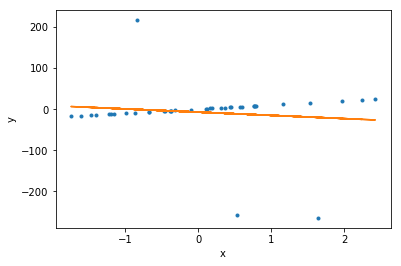

w = -7.845006
b = -7.235180


In [18]:
# generate random data
x = np.random.randn(40)
y = 10*x
# add random outliers
Noutliers = 3
y[:Noutliers] = -100*(x[:Noutliers]+np.random.randn(Noutliers))

# plot the points
plt.plot(x,y,'.')

X = x[:,None] # reshape for sklearn

# fit a linear regression model
lr = sklearn.linear_model.LinearRegression()
lr.fit(X,y)
plt.plot(x, lr.predict(X))

plt.xlabel('x')
plt.ylabel('y')
plt.show()


print("w = %f" % lr.coef_)
print("b = %f" % lr.intercept_)

For linear regression in one dimension our L1 objective becomes

$$f(w,b)=\displaystyle \sum_{n=1}^N\left|w x_n +b - y_n\right| $$

The gradient is

$$\frac{\partial f}{\partial w} = \sum_{n=1}^N  x_n \textrm{sign}\left(w x_n +b - y_n\right)$$ 

$$\frac{\partial f}{\partial b} = \sum_{n=1}^N  \textrm{sign}\left(w x_n +b - y_n\right)$$ 



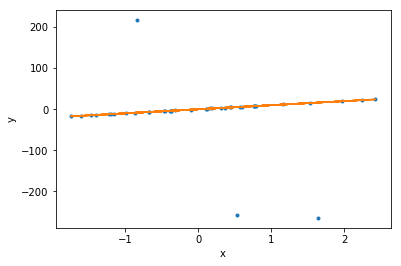

w = 9.907346
b = -0.220000


In [19]:
w = 0
b = 0
alpha = 0.01

Nsteps = 1000

for t in range(Nsteps):
    dLdw = np.sum(x*np.sign(w*x+b-y))
    dLdb = np.sum(np.sign(w*x+b-y))
    w -= alpha*dLdw
    b -= alpha*dLdb
    
plt.figure()
plt.plot(x,y,'.')
plt.plot(x,w*x+b)

plt.xlabel('x')
plt.ylabel('y')
plt.show()

print("w = %f" % w)
print("b = %f" % b)


Once again, "do not try this at home" because of the non-smoothness. Just doing it now to keep the example as simple as possible. 

## Gradient descent is not just for robust regression

We can use it for a large class of models, like logistic regression (DSCI 562) and deep learning (later in this course). With some caveats, **you are now empowered to minimize things!**

## Gradient descent is not the only game in town

There are many optimization algorithms out there. Gradient descent is not applicable in all contexts and it is certainly not the best method in all contexts! We focus on it because:

- it is relatively simple to understand and implement.
- the time complexity is linear in $d$ per iteration.
- we can generalize it to _stochastic gradient descent_, which is coming later in the course.

## The different decisions we make

We should try to keep separate (in our minds) the following choices:

- the model (e.g. linear)
- the loss (e.g. squared error)
- the optimization method (e.g. gradient descent)

We can (roughly) pick these independently of each other. Note quite because the choice of optimization method may depend on the choice of model/loss: e.g. we can use the normal equations as our optimization method if we're doing least squares.

## What space am I in?

A key skill is being able to move around (conceptually) between $x$ (data) space and $w$ (parameter) space. The above plots are in $y$ vs. $x$ space. Here's what the loss looks like in parameter space:

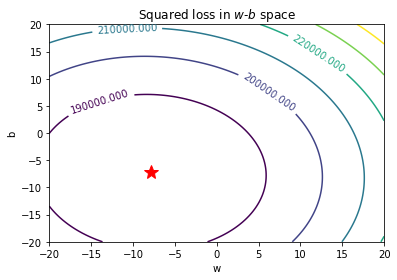

In [20]:
def plot_loss(loss_fun): # reading/understanding this plotting code is optional
    m = 100
    w_lin = np.linspace(-20.0, 20.0, m)
    b_lin = np.linspace(-20.0, 20.0, m)
    w_grid, b_grid = np.meshgrid(w_lin, b_lin)
    w_flat = w_grid.flatten()
    b_flat = b_grid.flatten()
    
    pred = w_flat[None]*X + b_flat[None]

    loss = loss_fun(pred, y) 
    loss_grid = np.reshape(loss,[m,m])

    plt.figure()
    CS = plt.contour(w_grid, b_grid, loss_grid)
    imin = np.argmin(loss_grid)
    plt.plot(w_flat[imin], b_flat[imin], 'r*', markersize=15)
    plt.xlabel('w')
    plt.ylabel('b')
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Squared loss in $w$-$b$ space')
    plt.show()
              
squared_loss_fun = lambda pred, y: np.sum((pred-y[:,None])**2,axis=0)
plot_loss(squared_loss_fun)

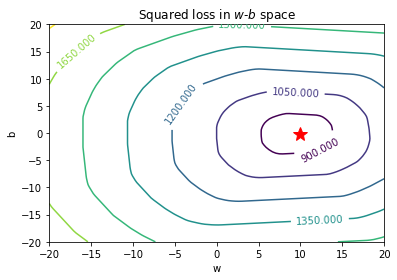

In [21]:
abs_loss_fun = lambda pred, y: np.sum(np.abs(pred-y[:,None]),axis=0)

plot_loss(abs_loss_fun)

Key intuition: every point in weight space corressponds to a _model_ (in this case a line) in input-output space.

- In general, doing supervised learning in $d$ dimensions, the data space will be mapping from $d$ dimensions to $1$ dimensional. 
- For linear models, the number of parameters is $d+1$ ($d$ weights plus an intercept), but this isn't necessarily the case for other models.

### (optional) Robust regression intuition

The loss is the sum of the absolute vertical distances between the points and the line. Let's assume you have 3 outliers all on the same side of the line, which are dragging the line up/down. Imagine shifting the line in towards the outliers by some small amount $\epsilon$. You have 3 points (the outliers) that are happier, meaning the loss goes down by $3\epsilon$. But, supposing there are 40 non-outlier points, you've upset those 40 points, meaning the loss goes up by $40 \epsilon$. So even moving the slightest bit upwards, or any amount for that matter, results in a worse (higher loss). That's why the robust fit is "perfect" rather than "close". You can think of it as voting and each point gets one vote; the outliers don't get more important votes than the non-outliers. So 40 beats 3. In real situations this reasoning doesn't apply exactly because the non-outliers will not lie perfectly on a line, and because you'll be in $d > 1$, but the general thought process applies.

We can go through the same thought experiment with least squares. If we move up by $\epsilon$ then the change in the loss function due to the outliers might be huge. For example if the outliers are currently 10 units away from the line and $\epsilon=1$ then we go from a loss of $10^2=100$ to $9^2=81$, so the loss decreases by 19 units for each outlier! Whereas for the non-outliers the loss increases from $0^2$ to $1^2$, and so the net increase is 1 unit of loss per point. Thus 3 outliers can actually overrule 40 non-outliers and the line starts to move. Until it reaches that equilibrium where the loss is minimized.

### (optional) smooth approximations and Huber loss

The absolute value loss is **non-smooth**. Although things above looked OK, in general it's not OK to naively ignore this issue (gradient descent will not asymptotically converge to the true solution, the above looks OK because we don't need a high accuracy solution). One way to avoid this issue is to use a **smooth approximation** to the loss. For example we can minimize the Huber objective

$$ \sum_{i=1}^n h \left( y_i-w^\top x_i\right) $$

where $$h(z) \equiv \begin{cases} 
      \frac{1}{2} z^2 & \textrm{if} \; |z|\leq 1 \\   |z|-\frac12 & \textrm{if} \; |z|>1
   \end{cases} $$

with gradient descent. This will hopefully give us robust regression because big distances aren't amplified in the objective.



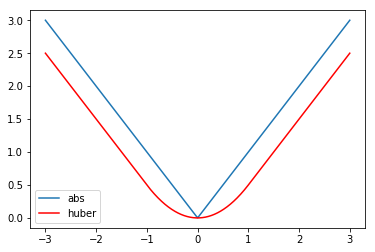

In [26]:
huber = lambda z: 0.5*z**2*(np.abs(z)<=1) + (np.abs(z)-0.5)*(np.abs(z)>1)

grid = np.linspace(-3,3,1000)
plt.plot(grid, np.abs(grid), label="abs")
plt.plot(grid, huber(grid), 'r', label="huber")
plt.legend()
plt.show()

For linear regression in one dimension our objective becomes

$$f(w,b)=\displaystyle \sum_{i=1}^n h\left(w x_i +b - y_i\right) $$

The gradient is

$$\frac{\partial f}{\partial w} = \sum_{i=1}^n  x_i h'\left( w x_i +b - y_i\right)$$ 

$$\frac{\partial f}{\partial b} = \sum_{i=1}^n  h'\left(w x_i +b - y_i\right)$$ 

where $$h'(z) = \begin{cases} 
       z & \textrm{if} \; |z|\leq 1 \\   \textrm{sign}(z) & \textrm{if} \; |z|>1
   \end{cases} $$

Minimizing this objective yields the robust fit, and in general is the right thing to do!

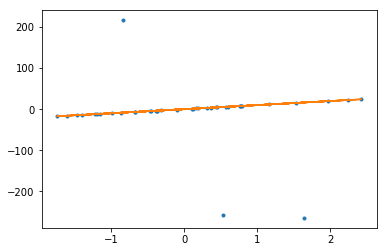

w = 9.924664
b = -0.026440


In [29]:
w = 0
b = 0
alpha = 0.01

Nsteps = 1000
yhat = lambda x,w,b: w*x+b

huber_deriv = lambda z: z*(np.abs(z)<=1) + np.sign(z)*(np.abs(z)>1)

for t in range(Nsteps):
    dLdw = -np.sum(x*huber_deriv(y-yhat(x,w,b)))
    dLdb = -np.sum(huber_deriv(y-yhat(x,w,b)))
    w -= alpha*dLdw
    b -= alpha*dLdb
    
plt.figure()
plt.plot(x,y,'.')
plt.plot(x,w*x+b)
plt.show()

print("w = %f" % w)
print("b = %f" % b)
